### Multi-colinearity

If we have a linear model
$$
y = \beta_0 + \beta_1 x_1 + \ldots + \beta_n x_p + \epsilon
$$
and $n$ observations $y_i$ and $x_{i1}, x_{i2}, \ldots, x_{ip}$ we can estimate the co-efficients $\beta$ by solving
$$
Y = X \beta
$$
Where $X = x_ij$ is an $n \times p$ matrix and $Y$ and $\beta$ are the vectors of observations and parameters. Because linear algebra routines work best with symmetric matrices we premultiply by $X^T$ and solve to get
$$
\beta = (X^T X)^{-1} X^T Y
$$

Now is there is a linear relationship between parameters e.g.
$$
x_2 = \lambda_0 + \lambda_1 x_1
$$
Then the matrix $X^T X$ doesn't have full rank and can't be inverted. In practice, say we were predicting education outcomes based on yearly and monthly salary where $\text{yearly} = 12 \times \text{monthly}$. Obviously yearly and monthly are not independent pieces of information and in practice we would just delete one of the variables. More interesting (and troublesome) is the case where
$$
x_2 \simeq \lambda_0 + \lambda_1 x_1
$$
e.g. if $\text{yearly} \simeq 12 \times \text{monthly}$ where yearly salary could be higher (due to bonuses) or lower (due to strikes) or just different (swapping jobs mid year). This is the case of approximate multi-collinearity which causes many headaches in practice...

/home/ra414/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


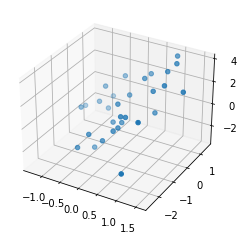

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

x = np.random.normal(0,1,30)
y = np.random.normal(0,1,30)
z = 2*x + y + np.random.normal(0,1,30)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)

plt.show()

Let's introduce some "nuisance" parameters and do some fits

In [2]:
n1 = np.random.normal(0,1,30)
n2 = -x + np.random.normal(0,0.01,30)
n3 = x + 0.5*y + np.random.normal(0,0.005,30)
Xmin = pd.DataFrame({"x":x, "y":y})
X = pd.DataFrame({"x":x, "y":y, "n1":n1, "n2":n2, "n3":n3})
Z = pd.DataFrame({"z":z})

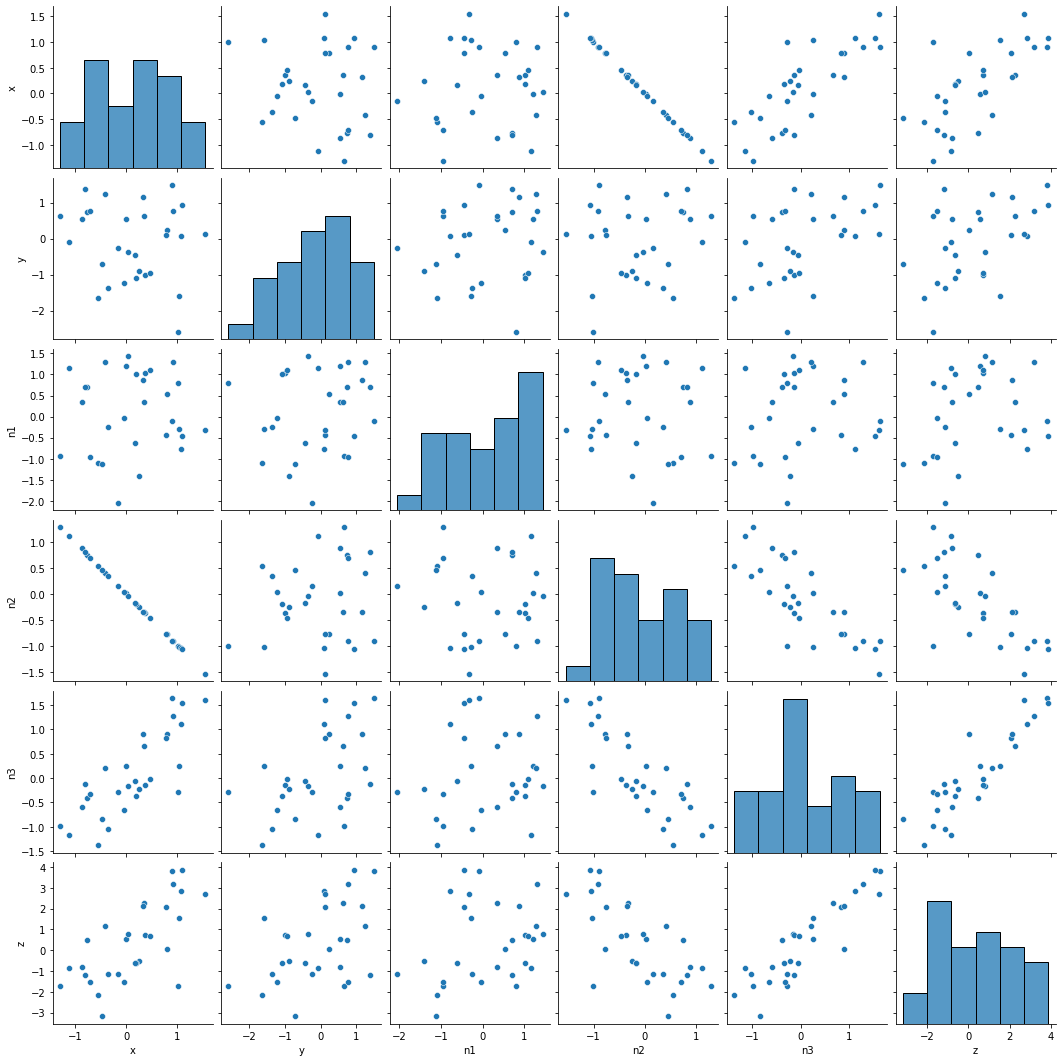

In [3]:
sns.pairplot( X.merge(Z, left_index=True, right_index=True) )

<AxesSubplot:>

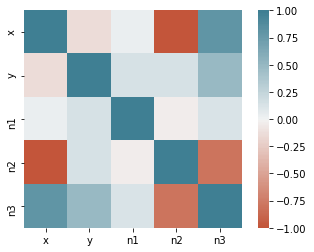

In [4]:
sns.heatmap(
    X.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [5]:
model = sm.OLS(z, Xmin).fit()
print( model.summary() )

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.797
Model:                            OLS   Adj. R-squared (uncentered):              0.782
Method:                 Least Squares   F-statistic:                              54.92
Date:                Sat, 01 Apr 2023   Prob (F-statistic):                    2.04e-10
Time:                        21:22:47   Log-Likelihood:                         -37.668
No. Observations:                  30   AIC:                                      79.34
Df Residuals:                      28   BIC:                                      82.14
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [6]:
model = sm.OLS(z, X).fit()
print( model.summary() )

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.821
Model:                            OLS   Adj. R-squared (uncentered):              0.786
Method:                 Least Squares   F-statistic:                              22.99
Date:                Sat, 01 Apr 2023   Prob (F-statistic):                    1.30e-08
Time:                        21:22:47   Log-Likelihood:                         -35.741
No. Observations:                  30   AIC:                                      81.48
Df Residuals:                      25   BIC:                                      88.49
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Compare these results
 - The R squared is the same (more or less)! So with or without the nuisance parameters we do an equally good job predicting the outcome.
 - But look at the coefficient values, none of them are significant! This is a tell tale sign of multi-colinearity. 
 
In bigger analyses this could happen on a subset of variables. Other signs are
  - See if there is a significant coefficient for the regression of one predictor on the outcome. If there is, but this vanishes when it's put in a multiple regression, you have problems.
  - Individual coefficients fail the significance tests, but they pass a joint test (F-test) for significance. Though could be a pain to do in practice (how do you group the variables?)

In [7]:
## Check each coeff individually
for p in X:
    model = sm.OLS(z, X[p]).fit()
    print("coeff", model.params,  "\npvalue", model.pvalues)

## Do the joint significance test
model = sm.OLS(z, X).fit()
A = np.identity(len(model.params)) ##confusing, see the docs https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.f_test.html
print(model.f_test(A))   
print(model.fvalue, model.f_pvalue)

coeff x    1.771564
dtype: float64 
pvalue x    0.000012
dtype: float64
coeff y    0.814585
dtype: float64 
pvalue y    0.013131
dtype: float64
coeff n1    0.532077
dtype: float64 
pvalue n1    0.150118
dtype: float64
coeff n2   -1.774322
dtype: float64 
pvalue n2    0.000013
dtype: float64
coeff n3    2.014636
dtype: float64 
pvalue n3    1.582800e-11
dtype: float64
<F test: F=22.99008790045832, p=1.3045507118462876e-08, df_denom=25, df_num=5>
22.99008790060899 1.3045507117605937e-08


So here we find each coefficient (apart from n1) is individually statistically significant. Comapre that to the model summary above where none of the were. We also find that they are together jointly significant under the F-test. Again, contrast this with the fact that none of the individual coefficients are distinguishable from 0 in the model summary.

### Principle Component Regression

We can decompose the data matrix $X$ into principle components
$$
X = U \Delta V^T
$$
For orthogonal $U$ and $V$ and diagonal $\Delta$. This transforms the normal matrix to
$$
X^T X = V \Lambda V^T
$$
Where $\Lambda = \Delta^2$ is the diagonal matrix of (real) eigenvalues of $X^TX$. If we keep only the top $K$ eigenvalues this is a rank $K$ approximation to the matrix.

Basically this is a "dimensional reduction" where we try to get rid of redundant information.

[5.49452067e-01 2.66690908e-01 1.83824007e-01 3.01352721e-05
 2.88253577e-06]


<BarContainer object of 5 artists>

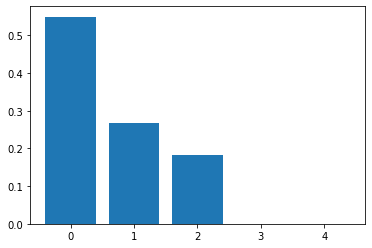

In [8]:
data = X.to_numpy()

##First center and normalise the data - this matters!
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)

from sklearn.decomposition import PCA
pca = PCA() ##compute the full PCA. Save time in practice using n_components=K!
pca.fit(data)

print(pca.explained_variance_ratio_)
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)


Only the first 3 coefficients explain any significant variance. So let's use those to do the regression.

In [9]:
##Waste time recomputing the PCA because it's simpler than doing the maths myself
pca = PCA(n_components=3) 
data_pca = pca.fit_transform(data)
Xpca = pd.DataFrame({"pc0":data_pca[:,0], "pc1":data_pca[:,1], "pc2":data_pca[:,2] })

##Now do the fit
model = sm.OLS(z, Xpca).fit()
print( model.summary() )

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.772
Method:                 Least Squares   F-statistic:                              34.88
Date:                Sat, 01 Apr 2023   Prob (F-statistic):                    1.97e-09
Time:                        21:22:47   Log-Likelihood:                         -37.813
No. Observations:                  30   AIC:                                      81.63
Df Residuals:                      27   BIC:                                      85.83
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

This is as it should be - there are two coefficients with significant predictive power (pc0 and pc1) and one coefficient without any (pc2). The problem is that we don't know what they are in terms of our original variables! They are some complicated linear combinations
$$
pc = c_1 x_1 + c_2 x_2 + \ldots c_p x_p
$$

Often in fact, the principle components can be reinterpreted as measuring something completely different than the input data. For example, when you do this kind of analysis on genetic data, using only the first two components, rather than thinking of them as measuring something genetic it is better to think of them as measuring latitude and longitude!

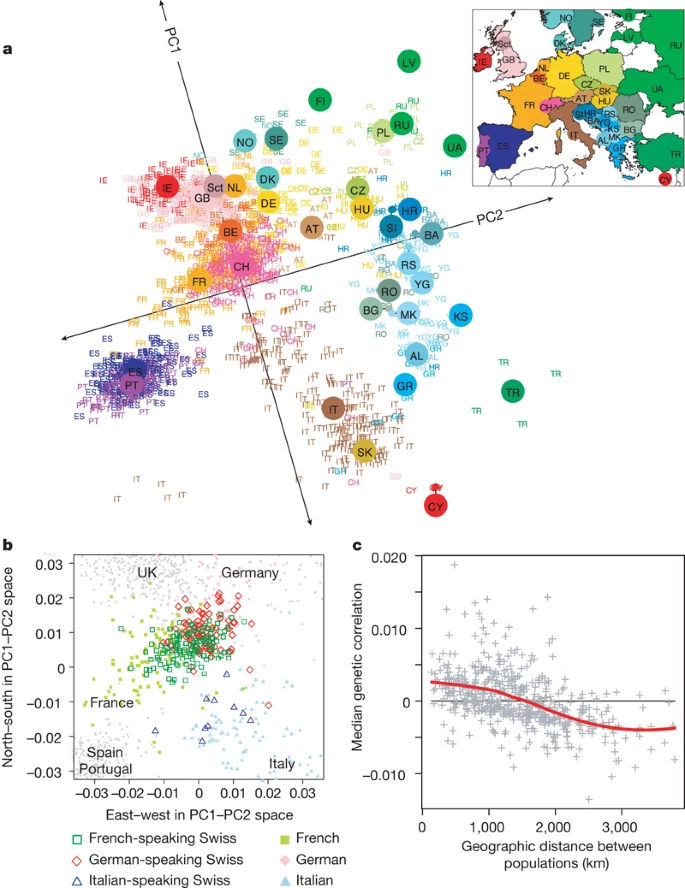
From [this article](https://www.nature.com/articles/nature07331)

So
 - Multicolinearity doesn't stop us from making predictions
 - It does stop us from interpreting the coefficients
 - PCA and similar approaches see [this](https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#sphx-glr-auto-examples-cross-decomposition-plot-pcr-vs-pls-py) can reorganize the data to remove the multicollinearity, but we lose the simple relationships between input variables and output (which is probably why we're doing linear regression)

#### Statistical Lasso
 
Ordinary linear regression finds the coefficients $\beta$ which minimise the sum of squared errors. Lasso does the same, subject to a constraint
$$
Q = \sum_i^n (y_i - (X \beta)_i )^2 \qquad s.t. \sum_j^p |\beta_j| \leq t
$$
Which is often written using Lagrange multipliers to enforce the constraint
$$
Q = \sum_i^n (y_i - (X \beta)_i )^2 + \lambda \sum_j^p |\beta_j| 
$$
This constraint forces many of the coefficients to zero so could be good for us.

In [10]:
##fit_regularized is statsmodel's version of Lasso regression if L1_wt=1
alpha = 0.5
model = sm.OLS(y, X).fit_regularized(method='elastic_net', alpha=alpha, L1_wt=1.0, refit=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.793e+32
Date:                Sat, 01 Apr 2023   Prob (F-statistic):                        0.00
Time:                        21:22:47   Log-Likelihood:                          1040.3
No. Observations:                  30   AIC:                                     -2079.
Df Residuals:                      29   BIC:                                     -2077.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x                   0          0        nan        nan           0           0
y              1.0000   3.84e-17   2.61e+16      0.000       1.000       1.000
n1                  0          0        nan        nan           0           0
n2                  0          0        nan        nan           0           0
n3                  0          0        nan        nan           0           0
==============================================================================
Omnibus:                        2.514   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.285   Jarque-Bera (JB):                2.105
Skew:                           0.532   Prob(JB):                        0.349
Kurtosis:                       2.256   Cond. No.                         397.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Quite weird behaviour. Ok, let's try something else...

#### Ridge Regression
Instead of the L1 constraint (sum of absolute values) we can try an L2 constraint on the parameters (sum of squares of parameters)
$$
Q = \sum_i^n (y_i - (X \beta)_i )^2 + \lambda \sum_j^p \beta_j^2
$$

In [11]:
##fit_regularized is statsmodel's version of Ridge regression if L1_wt=0
alpha = 0.5
model = sm.OLS(y, X).fit_regularized(method='elastic_net', alpha=alpha, L1_wt=0.0, refit=True)
print(model.params)

[-0.09325585  0.6041557   0.02681391  0.09400791  0.20812332]


Less weird, but doesn't really solve our problem and introduces other issues (it's a biased estimator, the estimate depends on a parameter, none of the coefficients are set to zero...) We can use some mix of Lasso and Ridge (called elastic net, hence the argument to the fit function) but I just don't really like these methods but perhaps I'm doing it wrong (e.g. I should probably standardize the input).

#### Making something up

In [64]:
from scipy.stats import pearsonr
import itertools

def correlated_bunch(data, cols, T):
    norm = 0;
    av = 0
    for i in range(1,len(cols)):
        for j in range(i):
            norm += 1
            r, p = pearsonr( X[cols[i]],X[cols[j]]) 
            if p > 0.05 or abs(r) < T: 
                return False
    return True
                
def get_correlated_sets(X, T=0.5):      
    cols = list(X.columns)
    i = len(cols) 
    correlated_sets = []
    while len(cols) > 1 and i > 1:   
        for c in itertools.combinations( cols, i ):
            ##horribly inefficient. Once you've rejected one pair you don't need to keep checking it!
            if correlated_bunch(X, c, T): 
                correlated_sets.append( set(c) )
                for e in c: cols.remove(e)
                i = len(cols)+1
                break
        i -= 1
    
    
    for e in cols: 
        correlated_sets.append( set([e]) )
    return correlated_sets

What I'm trying to do here is find all the subsets which mutual have pairwise correlations of at least T. The idea would be then to choose one from each (whichever is easiest to measure!) and do the fit. You definitely lose some information this way - chosing only one representative from each set and having only imperfect correlation among elements in the sets means that any information not captured in the representative element can't improve the fit. The idea is to pick T high enough not to lose too much, but low enough not to just have singleton sets.

Honestly, standard model selection is probably for the best here - see the notes on Model Selection for Regression.

In [48]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_boston
data = load_boston()
warnings.filterwarnings('once')
import pandas as pd
%matplotlib inline
X = pd.DataFrame(data.data, columns=data.feature_names);
y = pd.DataFrame(data.target, columns=["MedHouseVal"]);
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [50]:
get_correlated_sets(X)

[{'AGE', 'DIS', 'INDUS', 'NOX', 'ZN'},
 {'CRIM', 'RAD', 'TAX'},
 {'LSTAT', 'RM'},
 {'CHAS'},
 {'PTRATIO'},
 {'B'}]

The original house prices paper was trying to study pollution, which is the 'NOX' variable, so I'll use that. Just arbitrarily picking the others

In [51]:
model = sm.OLS(y, X[ ['NOX', 'TAX', 'RM', 'CHAS', 'PTRATIO', 'B'] ]).fit()
print( model.summary() )

                                 OLS Regression Results                                
Dep. Variable:            MedHouseVal   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              1519.
Date:                Sat, 01 Apr 2023   Prob (F-statistic):                   2.95e-317
Time:                        21:57:17   Log-Likelihood:                         -1585.1
No. Observations:                 506   AIC:                                      3182.
Df Residuals:                     500   BIC:                                      3208.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

This is a really good fit! The coefficients are also interpretable
 - NOX pollution makes prices go down
 - Houses with more rooms are more expensive
 - Houses next to the river are more expensive
 - Tax rates have (surprisingly?) no effect
 - Pupil teacher ratio has a small (surprisingly negative?) effect
 - Proportion of black residents has a small (surprisingly positive?) effect
This model doesn't minimise the BIC, for that see Model Selection Notes again. Note there we ignored the fact that RM and LSTAT were strongly correlated. 

In [52]:
pearsonr( X['RM'], X['LSTAT'])

PearsonRResult(statistic=-0.6138082718663957, pvalue=1.0330091329655203e-53)

Note the correlation isn't perfect and based on the previous analysis LSTAT may provide some additional info. We can try again with a higher threshold

In [65]:
get_correlated_sets(X, T=0.7)

[{'DIS', 'INDUS', 'NOX'},
 {'RAD', 'TAX'},
 {'CRIM'},
 {'ZN'},
 {'CHAS'},
 {'RM'},
 {'AGE'},
 {'PTRATIO'},
 {'B'},
 {'LSTAT'}]

In [66]:
model = sm.OLS(y, X[ ['NOX', 'TAX', 'CRIM', 'ZN', 'RM', 'CHAS', 'AGE', 'PTRATIO', 'B', 'LSTAT'] ]).fit()
print( model.summary() )

                                 OLS Regression Results                                
Dep. Variable:            MedHouseVal   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              1085.
Date:                Sat, 01 Apr 2023   Prob (F-statistic):                        0.00
Time:                        22:02:41   Log-Likelihood:                         -1541.2
No. Observations:                 506   AIC:                                      3102.
Df Residuals:                     496   BIC:                                      3145.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Bad news, now NOX is not significant. Probably because it is correlated with AGE and ZN which are now also in the fit. I'd pick a fairly low T and just sacrifice some possible fit quality (the R squared barely improved). This quality is probably statistically meaningless anyway.